1

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
from sklearn.svm import SVC

2

In [2]:
# ===== 1. Đọc dữ liệu =====
df_sample = pd.read_csv("online_shoppers_intention.csv")

In [3]:
df = df_sample.sample(frac = 0.1, random_state = 42)

3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1233 entries, 8916 to 7054
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           1233 non-null   int64  
 1   Administrative_Duration  1233 non-null   float64
 2   Informational            1233 non-null   int64  
 3   Informational_Duration   1233 non-null   float64
 4   ProductRelated           1233 non-null   int64  
 5   ProductRelated_Duration  1233 non-null   float64
 6   BounceRates              1233 non-null   float64
 7   ExitRates                1233 non-null   float64
 8   PageValues               1233 non-null   float64
 9   SpecialDay               1233 non-null   float64
 10  Month                    1233 non-null   object 
 11  OperatingSystems         1233 non-null   int64  
 12  Browser                  1233 non-null   int64  
 13  Region                   1233 non-null   int64  
 14  TrafficType              1

In [5]:
df['Revenue'] = df['Revenue'].map({True: 1, False: -1})

# ===== 3. One-hot encoding =====
df = pd.get_dummies(df, columns=['Month', 'VisitorType', 'Weekend'], drop_first=True)

# ===== 4. Xử lý missing value =====
df = df.dropna()

# ===== 5. Tách đặc trưng và nhãn =====
X = df.drop('Revenue', axis=1).values
y = df['Revenue'].values.astype(float)


In [6]:
print(df['Revenue'].value_counts())
df.describe()

Revenue
-1    1030
 1     203
Name: count, dtype: int64


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Revenue
count,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000
mean,2.344688,78.120823,0.447689,30.916400,31.875912,1194.643361,0.024519,0.045412,6.146652,0.062774,2.152474,2.384428,3.152474,4.046229,-0.670722
std,3.359000,157.027630,1.196883,132.227434,46.963460,1958.019302,0.052065,0.051403,19.211589,0.199637,0.886101,1.702696,2.322136,3.925066,0.742010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,163.000000,0.000000,0.013672,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,-1.000000
50%,1.000000,4.000000,0.000000,0.000000,18.000000,566.566667,0.003810,0.026923,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,-1.000000
75%,4.000000,98.000000,0.000000,0.000000,38.000000,1433.634921,0.018182,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000,-1.000000
max,20.000000,1640.590909,14.000000,1830.500000,517.000000,27009.859430,0.200000,0.200000,254.607158,1.000000,8.000000,13.000000,9.000000,20.000000,1.000000


In [7]:
# ===== 6. Train/Test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== 7. Chuẩn hóa =====
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# ===== 8. RBF Kernel =====
# def rbf_kernel(x1, x2, sigma=1.0):
#     return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * sigma ** 2))

def rbf_kernel(x1, x2, sigma=1.0):
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * sigma ** 2))

def rbf_cal(a, b):
    size_a = a.shape[0]
    size_b = b.shape[0]
    K = np.zeros((size_a, size_b))
    for i in range(size_a):
        for j in range(size_b):
            K[i, j] = rbf_kernel(a[i], b[j])
    return K

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Áp dụng SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# X_resampled = X_train
# y_resampled = y_train 

# Chuyển nhãn 0 thành -1
print(pd.Series(y_resampled).value_counts())
# y_resampled = np.where(y_resampled == 0, -1, 1)
# y_test = np.where(y_test == 0, -1, 1)
print("Các nhãn sau khi SMOTE:", np.unique(y_resampled))
print("Các nhãn sau khi SMOTE:", np.unique(y_test))

 1.0    826
-1.0    826
Name: count, dtype: int64
Các nhãn sau khi SMOTE: [-1.  1.]
Các nhãn sau khi SMOTE: [-1.  1.]


số lượng sol: 14
{'x': <1652x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <3304x1 matrix, tc='d'>, 'z': <3304x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.094428687028251e-09, 'relative gap': 7.71065600454448e-12, 'primal objective': -790.3904263705109, 'dual objective': -790.3904263766053, 'primal infeasibility': 4.818367926873179e-13, 'dual infeasibility': 5.476362286192686e-17, 'primal slack': 1.0645716294610926e-12, 'dual slack': 1.2319159930860653e-13, 'iterations': 9}
số lượng alpha: 1652
SV: [ True  True  True ...  True  True  True]
Số lượng support vectors: 1644
Giá trị alphas của SV: [1.         0.98436859 0.98436859 ... 0.76003447 1.         0.63743416]
số lượng alphas của SV: 1644
Nhãn của SV: [-1.  1.]
bbbbbbbbbbbbbbbbbbbb
Đây là b: [-0.01563141]
Các nhãn sau khi SMOTE: [-1.         -0.94748284 -0.83717459 -0.58527347 -0.57622375 -0.52139358
 -0.44875681 -0.39208896 -0.32765138 -0.31536471 -0.16376016 -0.11726959
 -0.10143148 -0.05262479 -0.04535242 -0.03662852 -0

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


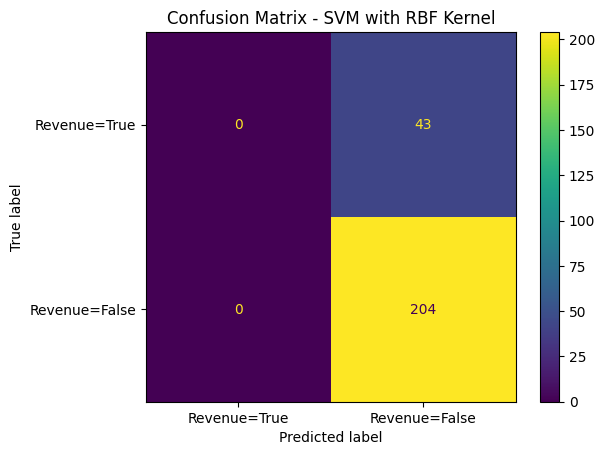

In [ ]:




# ===== 9. Tính ma trận Gram (train) =====
n_samples = X_resampled.shape[0]
# K = np.zeros((n_samples, n_samples))
# for i in range(n_samples):
#     for j in range(n_samples):
#         K[i, j] = rbf_kernel(X_resampled[i], X_resampled[j])
        
K = rbf_cal(X_resampled, X_resampled)

# ===== 10. QP input =====
C = 1.0 # Regularization parameter
P = matrix(np.outer(y_resampled, y_resampled) * K) #ok check roi
q = matrix(-np.ones(n_samples)) #ok check roi
G = matrix(np.vstack([-np.eye(n_samples), np.eye(n_samples)])) #ok check roi
h = matrix(np.hstack([np.zeros(n_samples), np.ones(n_samples) * C])) #ok check roi
A = matrix(y_resampled.reshape(1, -1)) #ok check roi
b = matrix(0.0) #0.0 hay la 0
#b = matrix(np.zeros(1)) #ok check roi

# ===== 11. Solve QP =====
solvers.options['show_progress'] = False #chua biet
solvers.options['abstol'] = 1e-10
solvers.options['reltol'] = 1e-10 #chua biet
solvers.options['feastol'] = 1e-10 #chua biet

sol = solvers.qp(P, q, G, h, A, b)
print("số lượng sol:", len(sol))
print(sol)
alphas = np.ravel(sol['x']) #ok check roi
print("số lượng alpha:", len(alphas))
# ===== 12. Support vectors =====
threshold = 1e-5
sv = (alphas > threshold) & (alphas <= C)
sv_X = X_resampled[sv] #support vectors
sv_y = y_resampled[sv]
sv_alpha = alphas[sv]
print("SV:", sv)

# 2. Xác định các Margin Vectors (0 < alpha_i < C)
margin_mask = (alphas > threshold) & (alphas < C - threshold)
margin_X = X_resampled[margin_mask]
margin_y = y_resampled[margin_mask]
print("Số lượng support vectors:", len(sv_X))
print("Giá trị alphas của SV:", sv_alpha)
print("số lượng alphas của SV:", len(sv_alpha))
print("Nhãn của SV:", np.unique(sv_y))
if len(margin_X) > 0:
    print("bbbbbbbbbbbbbbbbbbbb")
    # K_ms = rbf_kernel(margin_X, sv_X, sigma=1.0)
    K_ms = rbf_cal(margin_X, sv_X)
    # Tính b cho các Margin Vectors
    a_s = sv_alpha * sv_y
    b = np.dot((margin_y - np.dot(K_ms, a_s)).T, np.ones(len(margin_X))) / len(margin_X)
else:
    print("aaaaaaaaaaaaaaaaaaaaaaaa")
    # Fallback nếu không có margin vectors #can xem lai
    N = rbf_cal(sv_X[0:1], sv_X)
    a_s = sv_alpha * sv_y
    b = sv_y[0] - np.dot(N, a_s)[0]
    # b = sv_y[0] - np.dot(rbf_kernel(sv_X[0:1], sv_X, sigma=sigma), a_s)[0]

# ===== 13. Dự đoán =====
# hàm projext này bị sai, chạy ra kết quả có = 0
def project(x):
    x = np.asarray(x)
    if x.ndim == 1:
        x = x.reshape(1, -1)
    # Tính K_bs: kernel giữa x và các support vectors
    K_bs = rbf_cal(x, sv_X)
    # K_bs = rbf_kernel(x, sv_X, sigma=1.0)
    
    # Tính y = K_bs * a_s + b
    print("Đây là b:", np.unique(b))
    y = np.dot(K_bs, sv_alpha * sv_y) + b
    # Trả về mảng 1D
    print("Các nhãn sau khi SMOTE:", np.unique(y))
    return y.ravel()
    # return y
    # return y[0]  # Trả về giá trị scalar nếu input là 1 điểm

def predict(X_test):
    # return np.sign([project(x) for x in X_test])
    return np.sign(project(X_test))

# ===== 14. Dự đoán và đánh giá =====
y_pred = predict(X_test)
print("Các nhãn sau khi SMOTE:", np.unique(y_pred))
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label=1)
rec = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print(pd.Series(y_test).value_counts())
print(f" Evaluation on Test Set:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

# ===== 15. Confusion Matrix =====
cm = confusion_matrix(y_test, y_pred, labels=[1, -1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Revenue=True", "Revenue=False"])
disp.plot()
plt.title("Confusion Matrix - SVM with RBF Kernel")
plt.show()


Các nhãn sau khi SMOTE: [-1.]
 1.0    826
-1.0    826
Name: count, dtype: int64
-1.0    204
 1.0     43
Name: count, dtype: int64

🎯 Evaluation on Test Set:
Accuracy : 0.8259
Precision: 0.0000
Recall   : 0.0000
F1 Score : 0.0000


c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


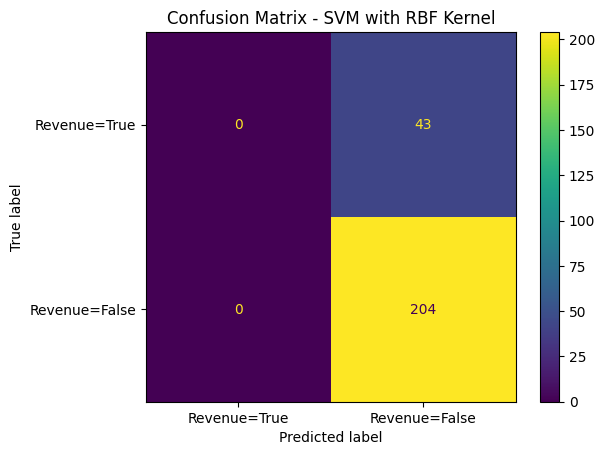

In [ ]:
model = SVC(C=1.0, kernel='rbf', gamma=0.5)
# model = SVC(C=1, kernel='poly', degree=4, gamma=0.1, coef0=1)
model.fit(X_resampled, y_resampled.reshape(-1,))
y_pre = model.predict(X_test)



print("Các nhãn sau khi SMOTE:", np.unique(y_pre))
acu = accuracy_score(y_test, y_pre)
preci = precision_score(y_test, y_pre, pos_label=1)
reca = recall_score(y_test, y_pre, pos_label=1)
f1s = f1_score(y_test, y_pre, pos_label=1)

print(pd.Series(y_resampled).value_counts())
print(pd.Series(y_test).value_counts())
print(f" Evaluation on Test Set:")
print(f"Accuracy : {acu:.4f}")
print(f"Precision: {preci:.4f}")
print(f"Recall   : {reca:.4f}")
print(f"F1 Score : {f1s:.4f}")

# ===== 15. Confusion Matrix =====
cm = confusion_matrix(y_test, y_pre, labels=[1, -1])
abc = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Revenue=True", "Revenue=False"])
abc.plot()
plt.title("Confusion Matrix - SVM with RBF Kernel")
plt.show()
